# Trouver et appliquer les règles à entropie nulle


## Importations
- codecs pour les encodages
- pandas et numpy pour les calculs sur tableaux
- matplotlib pour les graphiques
- itertools pour les itérateurs sophistiqués (paires sur liste, ...)

In [94]:
# -*- coding: utf8 -*-
import codecs,glob
import features
import re
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools as it
import networkx as nx
import pickle,yaml
#%pylab inline
#pd.options.display.mpl_style = 'default'
debug=False

In [107]:
%matplotlib inline

### Préparation des matrices de traits

In [2]:
features.add_config('bdlexique.ini')
fs=features.FeatureSystem('phonemes')

### Gestion du codage IPA

In [3]:
import unicodedata
def listerUnicode(chaine):
    result=[]
    comb=False
    prec=u""
    for char in chaine:
        print char,
        if unicodedata.combining(char):
            result.append(prec+char)
            prec=""
        else:
            result.append(prec)
            prec=char
    result.append(prec)
    return [r for r in result if r!=""]

In [4]:
ipaIn = listerUnicode(u"SZNêôârEHO")
ipaOut= [u"ʃ",u"ʒ",u"ŋ",u"ɛ̃",u"ɔ̃",u"ɑ̃",u"ʁ",u"ɛ",u"ɥ",u"ɔ"]
toipa = dict(zip(ipaIn, ipaOut))

S Z N ê ô â r E H O


In [5]:
def coderIPA(chaine,table=toipa):
    result=chaine
    for k in table:
        result=result.replace(k,table[k])
    return result

In [6]:
print coderIPA(u"SâZ piNpôN")

ʃɑ̃ʒ piŋpɔ̃ŋ


In [7]:
rep="/Users/gilles/ownCloud/Recherche/Boye/HDR/Data/Longitudinales/"
rep="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/Longitudinales/"
rep="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/StemSpaces/LongitudinalesRnd/"
rep="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/StemSpaces/Longitudinales/"
rep="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/lexique3/"
#rep="/Users/gilles/Desktop/lexique3/"
fichiers=glob.glob(rep+"*-X*-Regles.pkl")
samples=[f.rsplit("/",1)[-1].split("Regles")[0] for f in fichiers]
# samples={int(s.split("-")[1]):s for s in samples}
samples={int(s.split("-")[2]):s for s in samples}
samples

{0: 'Longitudinal-Lexique3-00-T150000000-F73539-X-',
 1: 'Longitudinal-Lexique3-01-T150000000-F254455-X-'}

In [162]:
sample=samples[0]
fRulesPMS="Regles.pkl"
fRulesPMO="Morphomes-Regles.pkl"
fLexique="paradigmes.csv"

# Classe pour la gestion des patrons, des classes et des transformations

In [10]:
class paireClasses:
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classes1=classesPaire(case1,case2)
        self.classes2=classesPaire(case2,case1)

    def ajouterPatron(self,n,patron,motif):
        if n==1:
            self.classes1.ajouterPatron(patron,motif)
        elif n==2:
            self.classes2.ajouterPatron(patron,motif)
        else:
            print "le numéro de forme n'est pas dans [1,2]",n

    def ajouterPaire(self,forme1,forme2):
        self.classes1.ajouterPaire(forme1,forme2)
        self.classes2.ajouterPaire(forme2,forme1)
        
    def calculerClasses(self):
        return(self.classes1,self.classes2)

    
class classesPaire:
    '''
    Gestion des patrons, des classes et des transformations
    
    ajouterPatron : ajoute un patron et son motif associé (MGL)
    ajouterPaire : ajoute une paire de formes, calcule la classe de la forme1 et la règle sélectionnée
    sortirForme : cacule les formes de sortie correspondant à la forme1 avec leurs coefficients respectifs
    '''
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classe={}
        self.nbClasse={}
        self.patrons={}
        self.entree={}
        self.sortie={}
    
    def ajouterPatron(self,patron,motif):
        self.patrons[patron]=motif
        (entree,sortie)=patron.split("-")
        self.entree[patron]=entree.replace(u".",u"(.)")
        self.sortie[patron]=remplacementSortie(sortie)
    
    def ajouterPaire(self,forme1,forme2):
        '''
        on calcule la classe de la paire idClasseForme et la règle sélectionnée
        on incrémente le compteur de la classe et celui de la règle sélectionnée à l'intérieur de la classe
        '''
        classeForme=[]
        regleForme=""
        for patron in self.patrons:
            if re.match(self.patrons[patron],forme1):
                classeForme.append(patron)
                '''
                le +"$" permet de forcer l'alignement à droite pour les transformations suffixales
                '''
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleForme=patron
        idClasseForme=", ".join(classeForme)
        if not idClasseForme in self.classe:
            self.classe[idClasseForme]={}
            self.nbClasse[idClasseForme]=0
        if not regleForme in self.classe[idClasseForme]:
            self.classe[idClasseForme][regleForme]=0
        self.nbClasse[idClasseForme]+=1
        self.classe[idClasseForme][regleForme]+=1

    def sortirForme(self,forme,contextFree=False):
        classeForme=[]
        sortieForme={}
        for patron in self.patrons:
            if contextFree:
                filterF1=".*"+patron.split("-")[0]+"$"
            else:
                filterF1=self.patrons[patron]
            if re.match(filterF1,forme):
                classeForme.append(patron)
        if classeForme:
            idClasseForme=", ".join(classeForme)
            if contextFree:
                nbClasse=self.nbClasseCF
                classe=self.classeCF
            else:
                nbClasse=self.nbClasse
                classe=self.classe
            if idClasseForme in nbClasse:
                nTotal=nbClasse[idClasseForme]
                for patron in classe[idClasseForme]:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(classe[idClasseForme][patron])/nTotal
            else:
#                if debug: 
#                    print (forme, file=logfile)
#                    print ("pas de classe",idClasseForme, file=logfile)
#                    print ("%.2f par forme de sortie" % (float(1)/len(classeForme)), file=logfile)
                nTotal=len(classeForme)
                for patron in classeForme:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(1)/nTotal
#        else:
#            if debug:
#                print (forme, file=logfile) 
#                print ("pas de patron", file=logfile)
        return sortieForme
        

## Ouvrir les fichiers de règles

In [11]:
def openRules(numero,typeRules="PMS"):
    rules=None
    if typeRules=="PMS" and numero in samples:
        with open(rep+samples[numero]+fRulesPMS, 'rb') as input:
            rules = pickle.load(input)
    elif typeRules=="PMO" and numero in samples:
        with open(rep+samples[numero]+fRulesPMO, 'rb') as input:
            rules = pickle.load(input)
    return rules

In [13]:
numero=0
typeRules="PMO"
avecContexte=True

In [14]:
sample

'Longitudinal-Lexique3-00-T150000000-F73539-X-'

In [15]:
#rules=openRules(numero,typeRules=typeRules)
with open(rep+sample+"Regles.pkl", 'rb') as input:
    rules = pickle.load(input)

In [169]:
nbLexemes=pd.read_csv(rep+sample+"paradigmes.csv", sep=";",index_col=False).count().lexeme

In [133]:
def entropie(L):
    total=float(sum(L))
    result=0
    for n in L:
        pourcentage=n/total
        result-=pourcentage*np.log2(pourcentage)
    return result

def entropiePaire(case1,case2):
    lEntropies={}
    for k,v in rules[(case1,case2)].classe.iteritems():
        lEntropies[k]={}
        lDistribution=[n for t,n in v.iteritems()]
        lEntropies[k]["p"]=sum(lDistribution)
        if len(lDistribution)<2:
            lEntropies[k]["e"]=0
        else:
            lEntropies[k]["e"]=entropie(lDistribution)
    totalPopulation=float(sum([lEntropies[t]["p"] for t in lEntropies]))
    totalEntropie=0
    for k,v in lEntropies.iteritems():
        lEntropies[k]["pe"]=lEntropies[k]["p"]/totalPopulation*lEntropies[k]["e"]
        totalEntropie+=lEntropies[k]["pe"]
    return totalEntropie,totalPopulation,lEntropies
        
            

In [63]:
#entropie([3,5,1])
entropiePaire("fi1P","fi1S")

(0.021367126186911643,
 614,
 {u'j6r\xf4-rE, \xf4-E': {'e': 0.91829583405448956,
   'p': 9,
   'pe': 0.013460362388420856},
  u'\xf4-E': {'e': 0, 'p': 600, 'pe': 0.0},
  u'\xf4-E, r\xf4-j6rE': {'e': 0.97095059445466858,
   'p': 5,
   'pe': 0.0079067637984907863}})

In [134]:
dfEntropieRegles=pd.DataFrame(columns=u"case1 case2 entropie population".split(" "))
for k,v in rules.iteritems():
    kEntropie,kPopulation,_=entropiePaire(k[0],k[1])
    seriesEntropieRegles=pd.Series([k[0],k[1],kEntropie,kPopulation],index=dfEntropieRegles.columns)
    dfEntropieRegles=dfEntropieRegles.append(seriesEntropieRegles,ignore_index=True)
dfEntropieRegles

,case1,case2,entropie,population
0,ps2P,is1S,0.000000,16.0
1,ii3S,ps3P,0.025747,107.0
2,pc2S,ai2P,0.000000,11.0
3,is2S,pc3P,0.000000,8.0
4,ps2S,ii2P,0.133887,280.0
5,pc2P,ai2P,0.000000,11.0
6,ii3P,pi2P,0.001220,1640.0
7,fi3P,pi2P,0.273516,890.0
8,pi2S,ps3P,0.071840,96.0
9,pc1P,pi2S,0.060305,227.0


### Calcul de l'entropie globale

In [173]:
dfEntropieRegles["missing"]=nbLexemes-dfEntropieRegles.population
croisementsPopulations=dfEntropieRegles.population.sum()
missingPopulations=dfEntropieRegles.missing.sum()
croisementsPopulations,missingPopulations

(1650785, 12352999)

In [175]:
sum(dfEntropieRegles.entropie*dfEntropieRegles.population/croisementsPopulations)

0.18155248361032625

In [176]:
sum(dfEntropieRegles.entropie*dfEntropieRegles.missing/missingPopulations)

0.13805590261157055

# Préparation de la heatmap

In [102]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("talk")
sns.set_palette("husl")

In [103]:
def sortDiagValues(df):
    return pd.Series(np.diag(df),index=df.index).sort_values(ascending=False).index.tolist()

In [140]:
def heatmap(df,fmt=".2g"):
    fig, ax = plt.subplots(figsize=(60,50))
#    ax.set_ylabel('Cells sorted by decreasing frequency')    
#    ax.set_xlabel('Cells sorted by decreasing frequency')
    sns.heatmap(df,cmap="Oranges",norm=norm,annot=True,fmt=fmt,cbar_kws={"ticks":bounds},ax=ax,cbar=True)
    return

In [158]:
df=dfEntropieRegles.pivot_table(index=["case1"],columns=["case2"],values="entropie")

In [159]:
#bounds = np.array([0, 3, 10, 30, 100, 300, 1000, 3000, 5000])
bounds = np.array([0,.001,.01,.1,1])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)

In [160]:
sortedSampleCases=sortDiagValues(df)
sortedSampleCases=[u'inf', u'ppMS', u'pi3S', u'ii3S', u'ppFS', u'pP', u'ppMP', u'pi3P', u'pi1S', u'ii3P', u'ai3S', u'ppFP', u'pI2S', u'pI2P', u'pi2P', u'ii1S', u'pi2S', u'fi3S', u'pc3S', u'ai3P', u'pi1P', u'fi1S', u'ai1S', u'pI1P', u'fi3P', u'ii2S', u'pc1S', u'ii1P', u'pc3P', u'is3S', u'ii2P', u'fi2P', u'fi2S', u'fi1P', u'ps3S', u'pc2S', u'ps2S', u'ps1S', u'ai1P', u'pc2P', u'pc1P', u'is3P', u'ai2S', u'ps3P', u'is1S', u'ps2P', u'ps1P', u'ai2P', u'is2S', u'is1P', u'is2P']
print sortedSampleCases
df=df[sortedSampleCases]
df=df.reindex(sortedSampleCases[::-1])

[u'inf', u'ppMS', u'pi3S', u'ii3S', u'ppFS', u'pP', u'ppMP', u'pi3P', u'pi1S', u'ii3P', u'ai3S', u'ppFP', u'pI2S', u'pI2P', u'pi2P', u'ii1S', u'pi2S', u'fi3S', u'pc3S', u'ai3P', u'pi1P', u'fi1S', u'ai1S', u'pI1P', u'fi3P', u'ii2S', u'pc1S', u'ii1P', u'pc3P', u'is3S', u'ii2P', u'fi2P', u'fi2S', u'fi1P', u'ps3S', u'pc2S', u'ps2S', u'ps1S', u'ai1P', u'pc2P', u'pc1P', u'is3P', u'ai2S', u'ps3P', u'is1S', u'ps2P', u'ps1P', u'ai2P', u'is2S', u'is1P', u'is2P']


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5]),
 <a list of 51 Text yticklabel objects>)

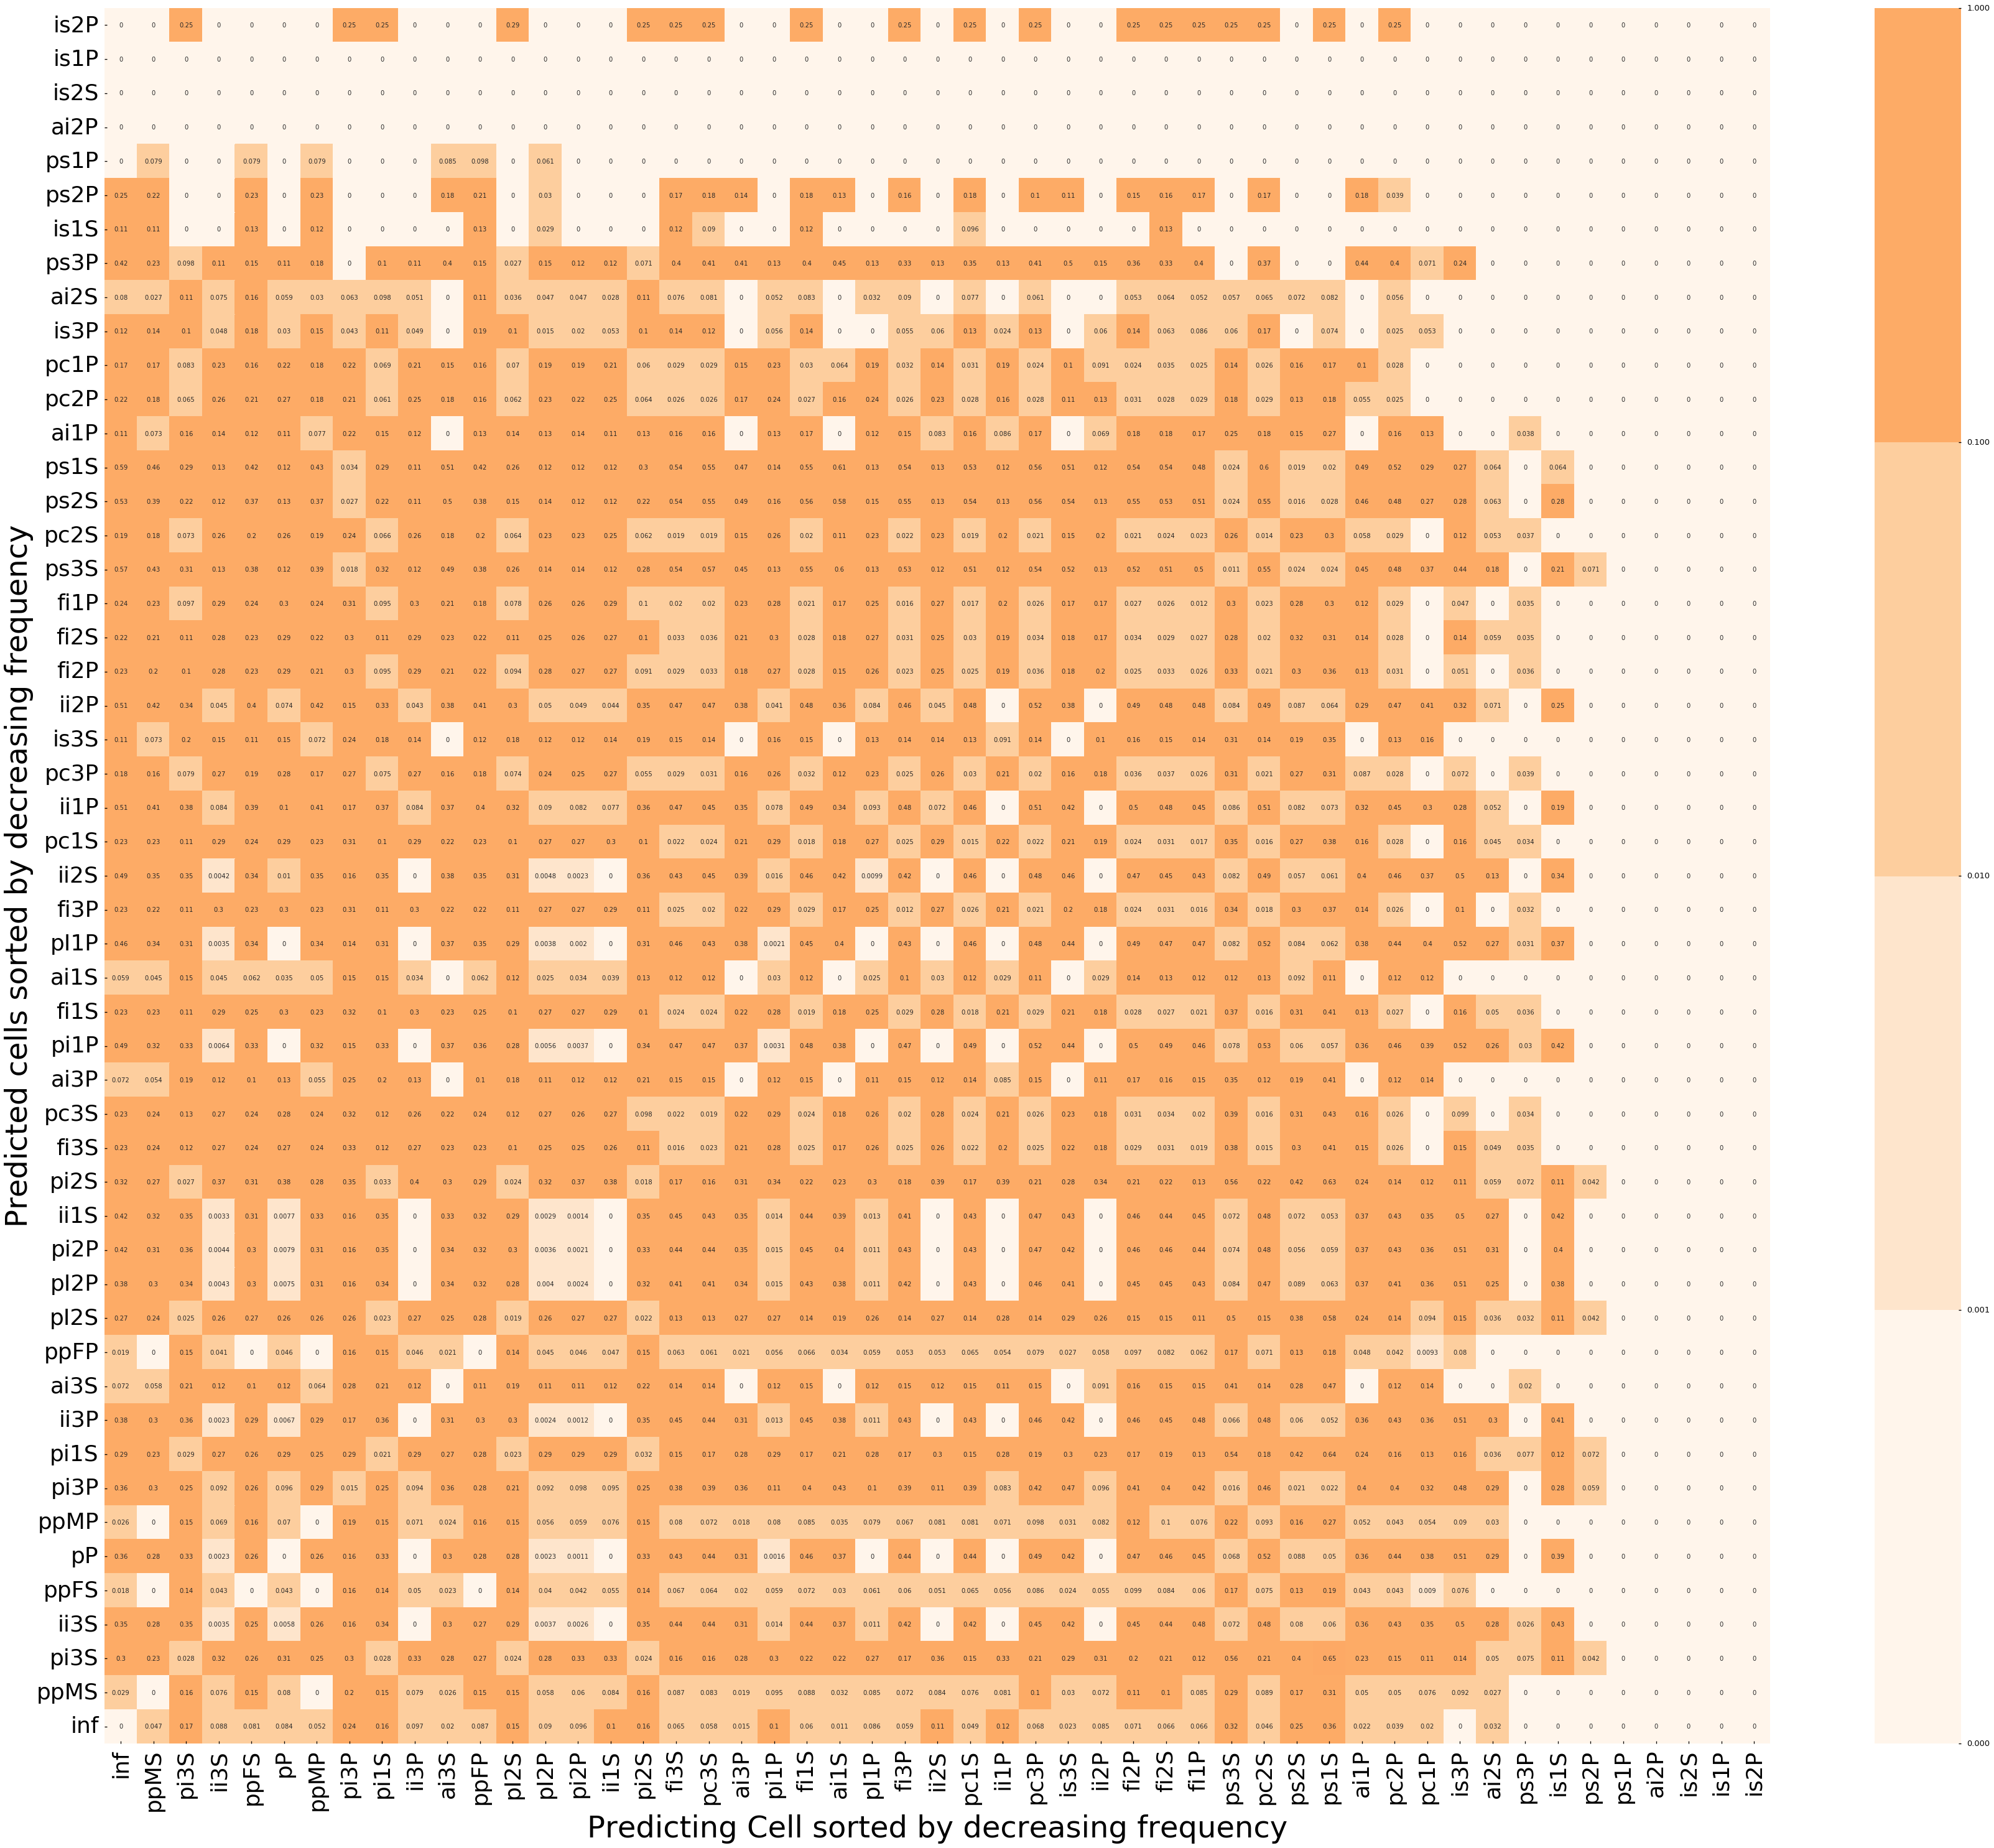

In [161]:
heatmap(df)
plt.xlabel('Predicting Cell sorted by decreasing frequency',fontsize=48) 
plt.ylabel('Predicted cells sorted by decreasing frequency',fontsize=48) 
plt.xticks(fontsize=36, rotation=90) 
plt.yticks(fontsize=36, rotation=0) 

['pi1P', 'pi2P', 'ii1S', 'ii1P', 'ii2S', 'ii2P', 'ii3S', 'ii3P', 'pi3P', 'pi1S', 'pi2S', 'pi3S', 'pP', 'pI2S', 'pI1P', 'pI2P', 'ps1S', 'ps2S', 'ps3S', 'ps3P', 'ps1P', 'ps2P', 'inf', 'fi1S', 'fi1P', 'fi2S', 'fi2P', 'fi3S', 'fi3P', 'pc1S', 'pc1P', 'pc2S', 'pc2P', 'pc3S', 'pc3P', 'ai1S', 'ai1P', 'ai2S', 'ai2P', 'ai3S', 'ai3P', 'is1S', 'is1P', 'is2S', 'is2P', 'is3S', 'is3P', 'ppMS', 'ppMP', 'ppFS', 'ppFP']


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5]),
 <a list of 51 Text yticklabel objects>)

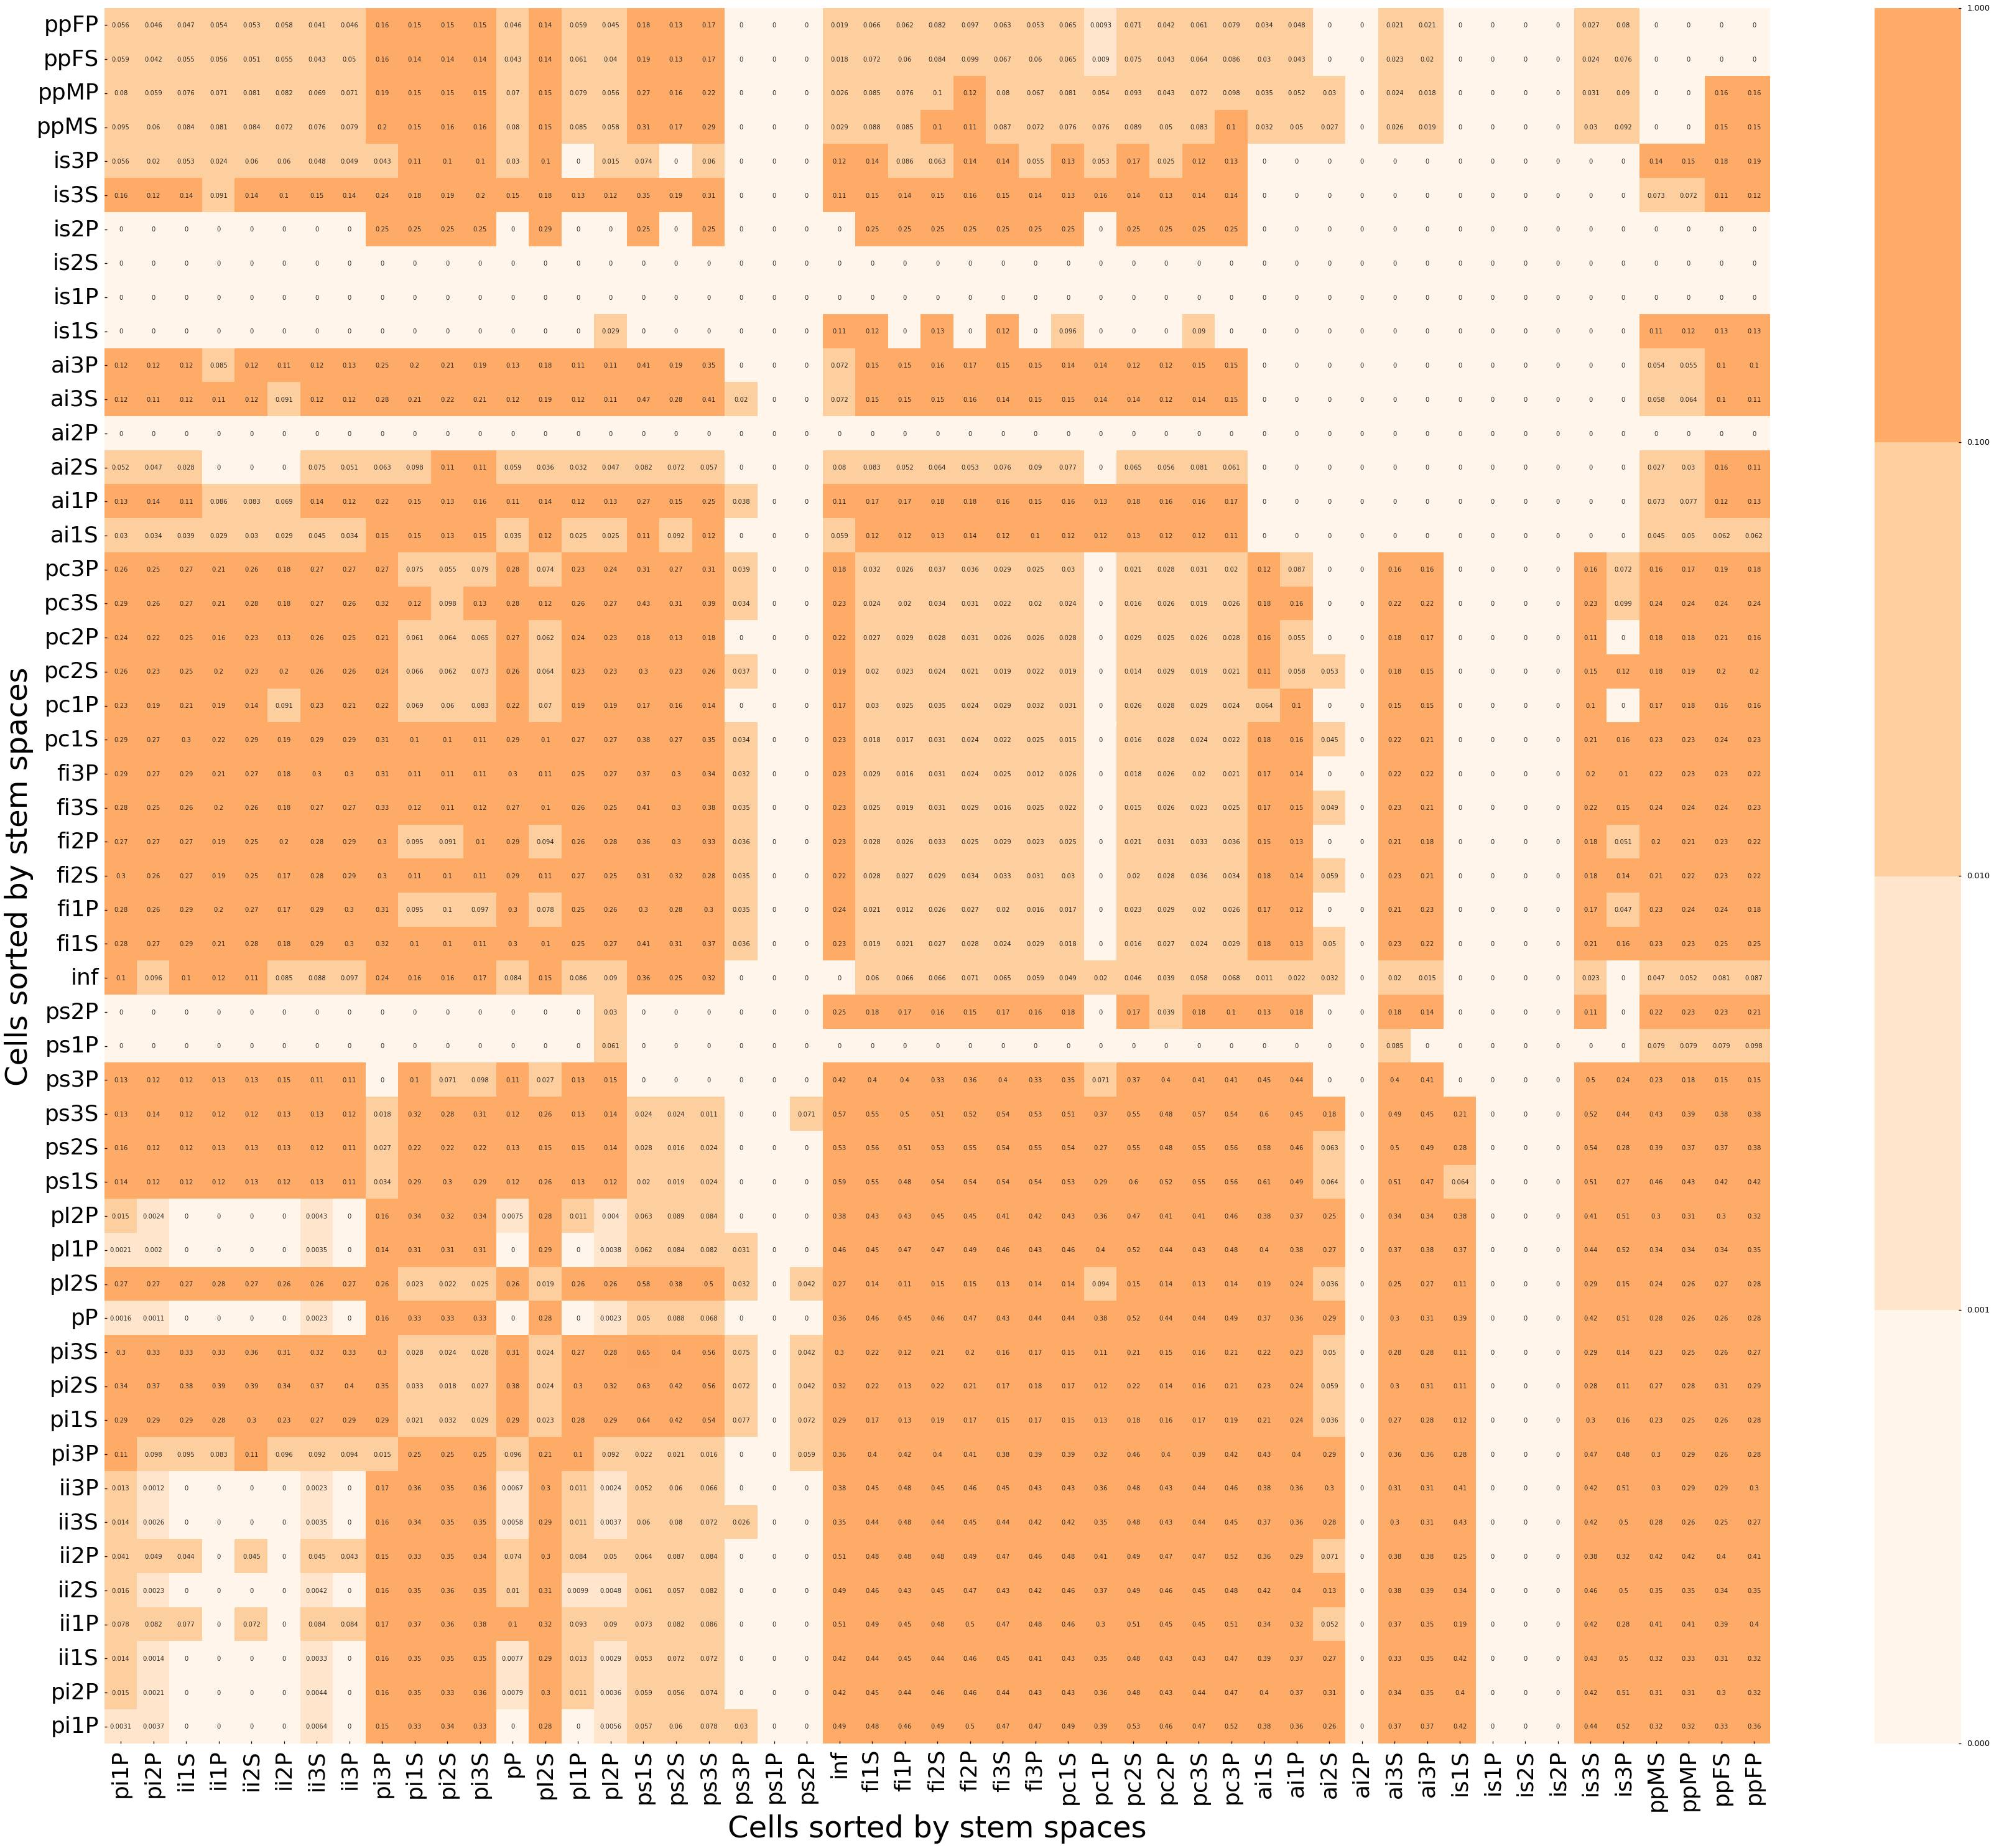

In [128]:
sortedSampleCases=sum(etCells,[])
print sortedSampleCases
df=df[sortedSampleCases]
df=df.reindex(sortedSampleCases[::-1])
heatmap(df)
plt.xlabel('Cells sorted by stem spaces',fontsize=48) 
plt.ylabel('Cells sorted by stem spaces',fontsize=48) 
plt.xticks(fontsize=36, rotation=90) 
plt.yticks(fontsize=36, rotation=0) 

In [148]:
dfEntropieRegles.population=dfEntropieRegles.population.astype(int)

In [149]:
df=dfEntropieRegles.pivot_table(index=["case1"],columns=["case2"],values="population")

In [153]:
#bounds = np.array([0, 3, 10, 30, 100, 300, 1000, 3000, 5000])
bounds = np.array([0,10,100,1000,5000])
#bounds = np.array([0,.001,.01,.1,1])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)

In [154]:
sortedSampleCases=sortDiagValues(df)
sortedSampleCases=[u'inf', u'ppMS', u'pi3S', u'ii3S', u'ppFS', u'pP', u'ppMP', u'pi3P', u'pi1S', u'ii3P', u'ai3S', u'ppFP', u'pI2S', u'pI2P', u'pi2P', u'ii1S', u'pi2S', u'fi3S', u'pc3S', u'ai3P', u'pi1P', u'fi1S', u'ai1S', u'pI1P', u'fi3P', u'ii2S', u'pc1S', u'ii1P', u'pc3P', u'is3S', u'ii2P', u'fi2P', u'fi2S', u'fi1P', u'ps3S', u'pc2S', u'ps2S', u'ps1S', u'ai1P', u'pc2P', u'pc1P', u'is3P', u'ai2S', u'ps3P', u'is1S', u'ps2P', u'ps1P', u'ai2P', u'is2S', u'is1P', u'is2P']
print sortedSampleCases
df=df[sortedSampleCases]
df=df.reindex(sortedSampleCases[::-1])

[u'inf', u'ppMS', u'pi3S', u'ii3S', u'ppFS', u'pP', u'ppMP', u'pi3P', u'pi1S', u'ii3P', u'ai3S', u'ppFP', u'pI2S', u'pI2P', u'pi2P', u'ii1S', u'pi2S', u'fi3S', u'pc3S', u'ai3P', u'pi1P', u'fi1S', u'ai1S', u'pI1P', u'fi3P', u'ii2S', u'pc1S', u'ii1P', u'pc3P', u'is3S', u'ii2P', u'fi2P', u'fi2S', u'fi1P', u'ps3S', u'pc2S', u'ps2S', u'ps1S', u'ai1P', u'pc2P', u'pc1P', u'is3P', u'ai2S', u'ps3P', u'is1S', u'ps2P', u'ps1P', u'ai2P', u'is2S', u'is1P', u'is2P']


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5]),
 <a list of 51 Text yticklabel objects>)

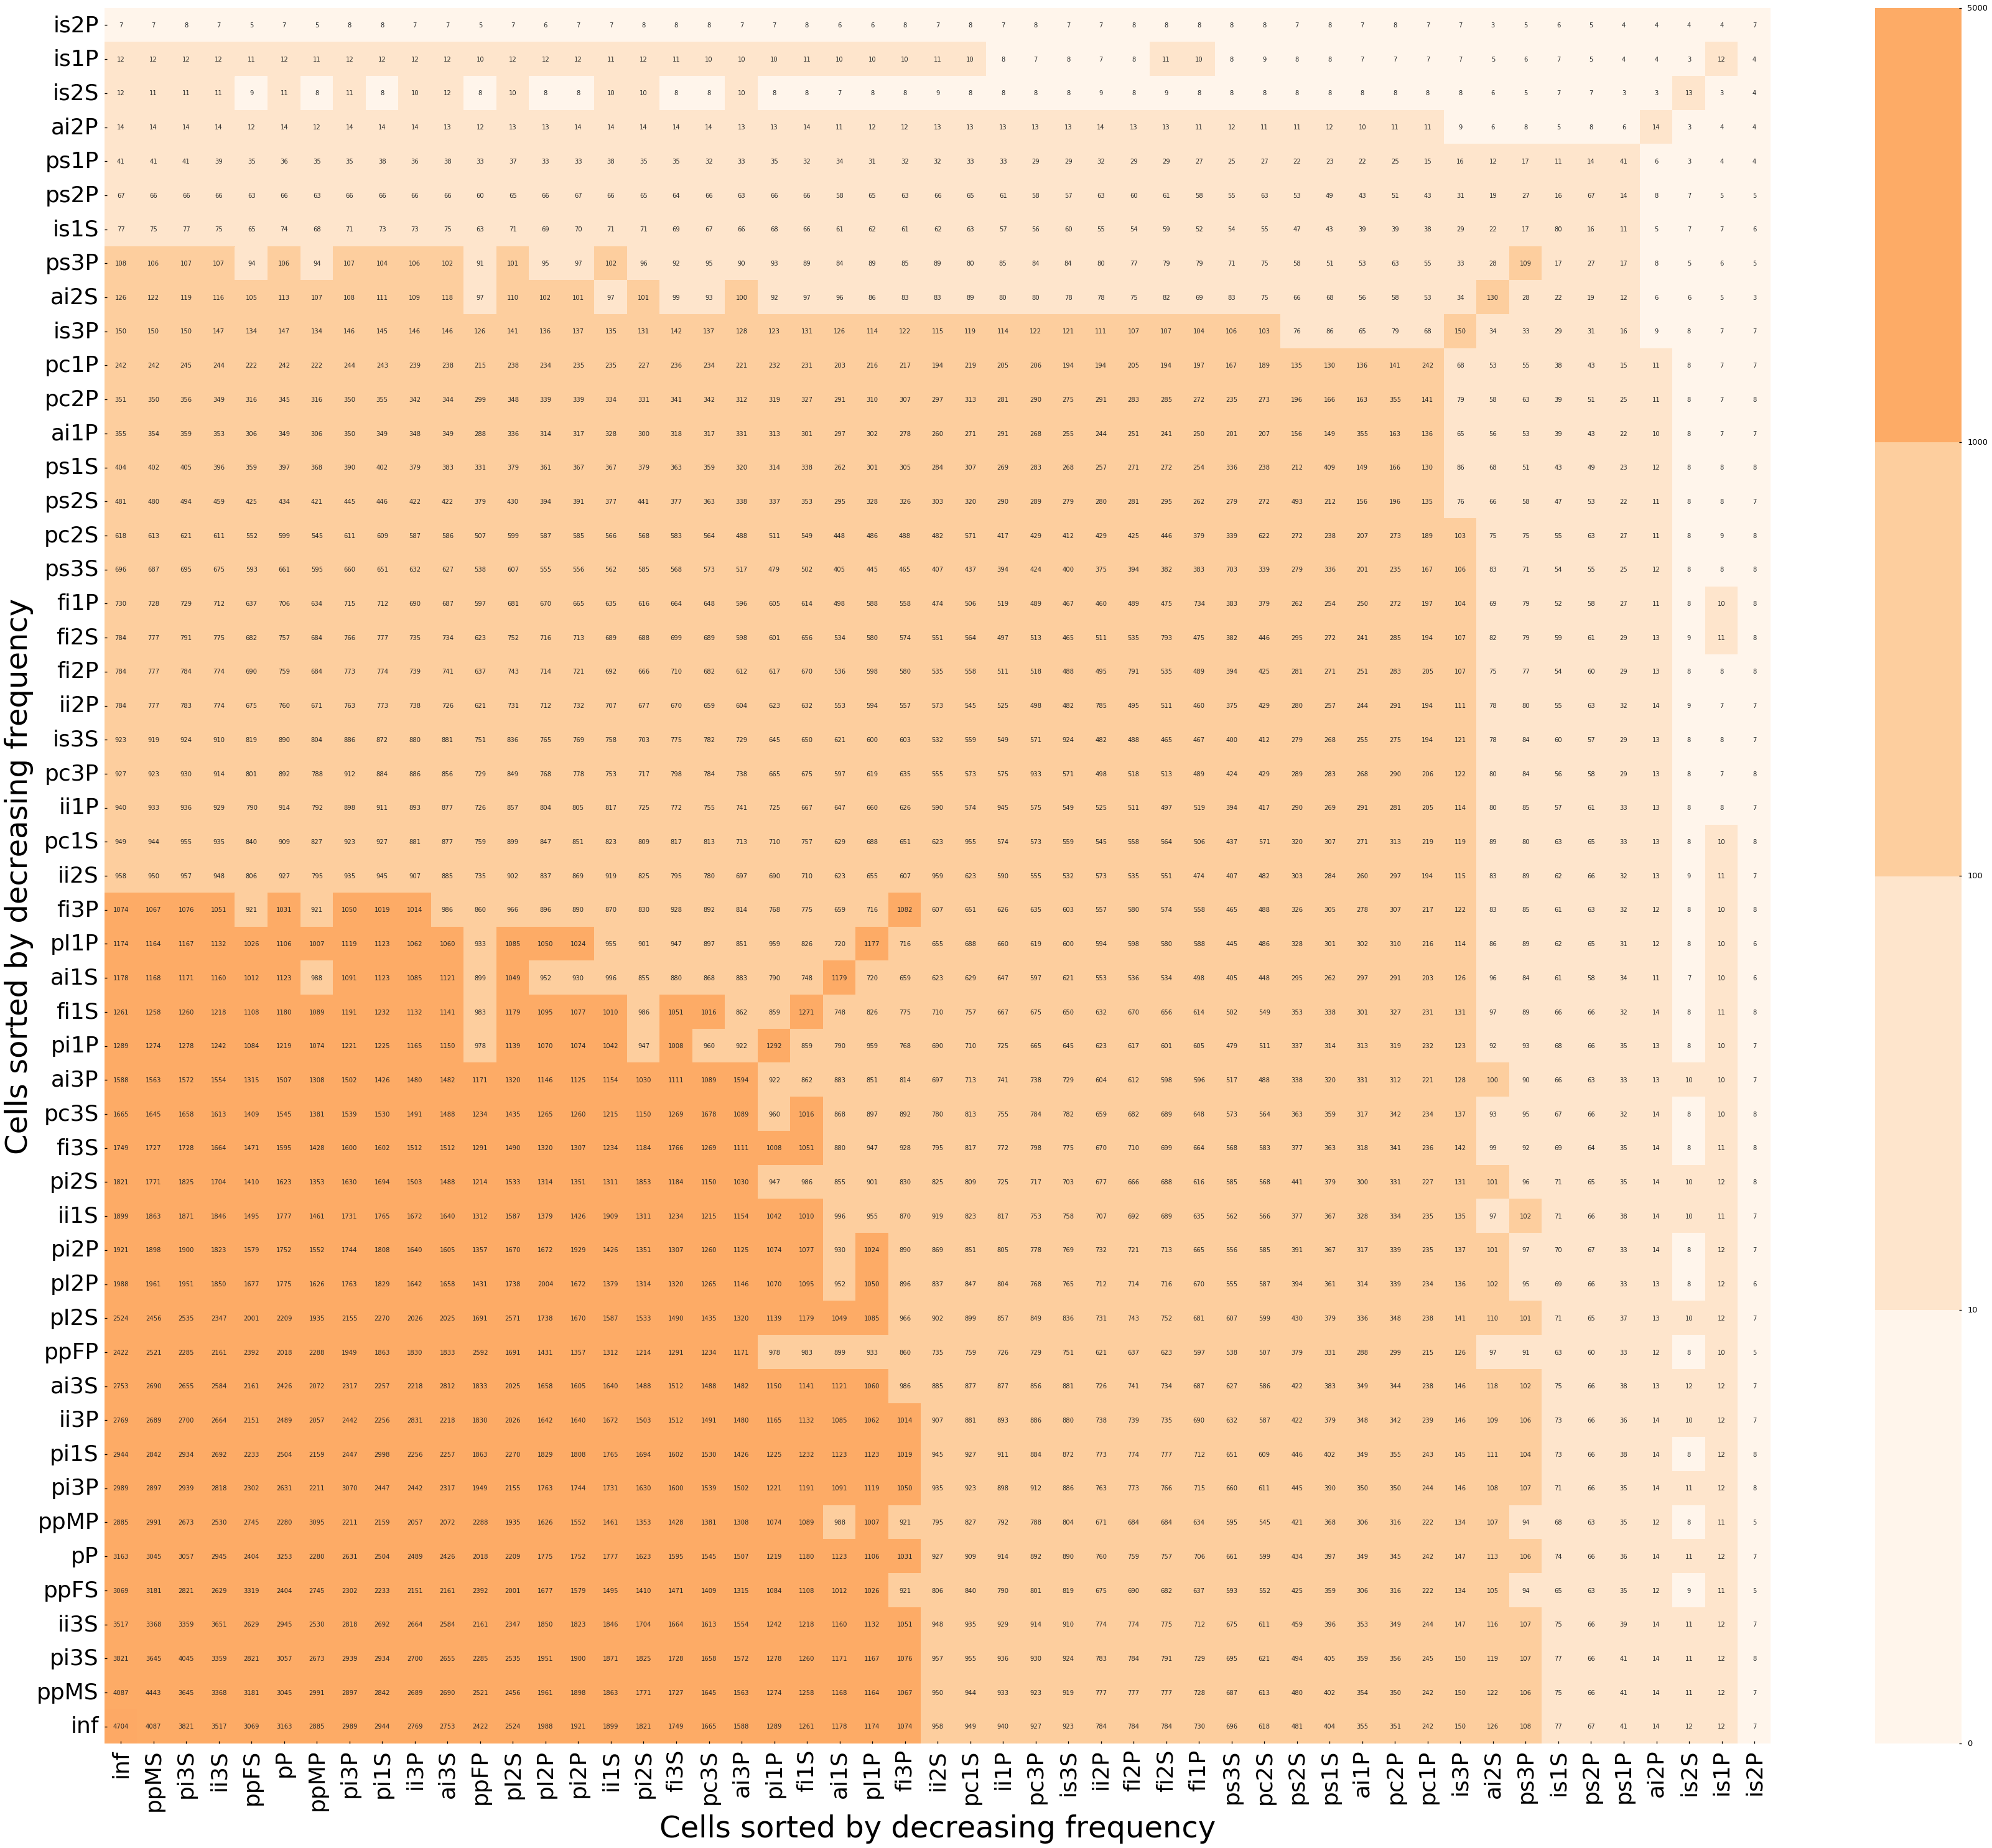

In [155]:
heatmap(df,fmt="d")
plt.xlabel('Cells sorted by decreasing frequency',fontsize=48) 
plt.ylabel('Cells sorted by decreasing frequency',fontsize=48) 
plt.xticks(fontsize=36, rotation=90) 
plt.yticks(fontsize=36, rotation=0) 

In [157]:
dfP

case2,inf,ppMS,pi3S,ii3S,ppFS,pP,ppMP,pi3P,pi1S,ii3P,...,is3P,ai2S,ps3P,is1S,ps2P,ps1P,ai2P,is2S,is1P,is2P
case1,,,,,,,,,,,,,,,,,,,,,
is2P,7,7,8,7,5,7,5,8,8,7,...,7,3,5,6,5,4,4,4,4,7
is1P,12,12,12,12,11,12,11,12,12,12,...,7,5,6,7,5,4,4,3,12,4
is2S,12,11,11,11,9,11,8,11,8,10,...,8,6,5,7,7,3,3,13,3,4
ai2P,14,14,14,14,12,14,12,14,14,14,...,9,6,8,5,8,6,14,3,4,4
ps1P,41,41,41,39,35,36,35,35,38,36,...,16,12,17,11,14,41,6,3,4,4
ps2P,67,66,66,66,63,66,63,66,66,66,...,31,19,27,16,67,14,8,7,5,5
is1S,77,75,77,75,65,74,68,71,73,73,...,29,22,17,80,16,11,5,7,7,6
ps3P,108,106,107,107,94,106,94,107,104,106,...,33,28,109,17,27,17,8,5,6,5
ai2S,126,122,119,116,105,113,107,108,111,109,...,34,130,28,22,19,12,6,6,5,3


# Résidus

In [ ]:
zeroEntropie=[]
for paire in rules:
    classe=rules[paire].classe
    c1,c2=paire
    if c1!=c2:
        zero=True
        print paire
        for transformation in classe:
            choix=classe[transformation]
            if len(choix)>1:
                print choix
                zero=False
        if zero:
            print "zéro",choix
            zeroEntropie.append(paire)
        print

In [ ]:
zeroPop={}
for paire in zeroEntropie:
    for t in rules[paire].classe:
        pop=0
        for c in rules[paire].classe[t]:
            pop+=rules[paire].classe[t][c]
        zeroPop[paire]=pop
    

In [ ]:
stemspaceThresh=100
stemspaceRules=[]
for k in sorted(zeroPop, key=zeroPop.get,reverse=True):
    print k, zeroPop[k]
    if zeroPop[k]>=stemspaceThresh:
        stemspaceRules.append(k)

In [ ]:
len(stemspaceRules)

In [ ]:
stemSpace=nx.Graph()
for c1,c2 in stemspaceRules:
    if (c2,c1) in stemspaceRules:
#        print c1,c2
        stemSpace.add_edge(c1,c2)
stemSpaceCliques=list(nx.find_cliques(stemSpace))
len(stemSpaceCliques),sorted(stemSpaceCliques,key=len,reverse=True)

In [ ]:
fSamplePMS="paradigmes.csv"
fSamplePMO="Morphomes-paradigmes.csv"

In [ ]:
def openSample(numero,typeSample="PMS"):
    result=None
    fSample=""
    if typeSample=="PMS" and numero in samples:
        fSample=rep+samples[numero]+fSamplePMS
    elif typeSample=="PMO" and numero in samples:
        fSample=rep+samples[numero]+fSamplePMO
    if fSample:
        result=pd.read_csv(rep+samples[numero]+fSamplePMS,sep=";",index_col=0,keep_default_na=False,encoding="utf8")
    return result    

In [ ]:
df=openSample(2,typeRules)

In [ ]:
def makeZeros(sampleFormes,inFormes=True,contextFree=True):
    series=sampleFormes.copy()
    series={k:v for k,v in series.iteritems() if v!=""}

    paires=rules.keys()
    formesC={}
    for c in series:
        if not c in formesC:
            formesC[c]=set()
        formesC[c].add(series[c])
        if debug: print c, series[c]
        formeC=series[c]
        pairesC=[(c1,c2) for (c1,c2) in paires if c1==c]
        for p in pairesC:
            formeP=rules[p].sortirForme(series[c],contextFree=contextFree)
            if formeP and len(formeP)==1:
                p1=p[1]
                if debug: print p1,formeP
                if p1 not in formesC:
                    formesC[p1]=set()
                formesC[p1].add(formeP.keys()[0])
    if inFormes:
        formesZero={k:list(v)[0] for k,v in formesC.iteritems() if len(v)==1}
    else:
        formesZero={k:list(v)[0] for k,v in formesC.iteritems() if len(v)==1 and k not in series}

    return formesZero

In [ ]:
def fillStemSpace(sampleFormes,inFormes=True,contextFree=True):
    series=sampleFormes.copy()
    series={k:v for k,v in series.iteritems() if v!=""}

    paires=stemspaceRules
    formesC={}
    for c in series:
        if not c in formesC:
            formesC[c]=set()
        formesC[c].add(series[c])
        if debug: print c, series[c]
        formeC=series[c]
        pairesC=[(c1,c2) for (c1,c2) in paires if c1==c]
        for p in pairesC:
            formeP=rules[p].sortirForme(series[c],contextFree=contextFree)
            if formeP and len(formeP)==1:
                p1=p[1]
                if debug: print p1,formeP
                if p1 not in formesC:
                    formesC[p1]=set()
                formesC[p1].add(formeP.keys()[0])
    if inFormes:
        formesZero={k:list(v)[0] for k,v in formesC.iteritems() if len(v)==1}
    else:
        formesZero={k:list(v)[0] for k,v in formesC.iteritems() if len(v)==1 and k not in series}

    return formesZero

In [ ]:
cases=[c for c in df.columns.tolist() if c!="lexeme"]
cases=sorted(cases)

In [ ]:
lexemes=u"clore éclore falloir valoir".split(" ")
lexemes=[l for l in df["lexeme"].tolist() if not l.endswith(u"er")]
lexemes

In [ ]:
dfNew=df.copy()
for lexeme in lexemes:
    index=df.loc[df['lexeme']==lexeme].index.values
    if index:
        i=index[0]
        sampleFormes=df.iloc[i].to_dict()
        sampleFormes={k:v for k,v in sampleFormes.iteritems() if v!=""}
        lexemeI=sampleFormes["lexeme"]
        print lexemeI,
#        formesZero=makeZeros(sampleFormes,inFormes=False)
        formesZero=fillStemSpace(sampleFormes,inFormes=False,contextFree=not avecContexte)
        for case in cases:
            if case in sampleFormes:
#                print "\t",case,"\t  ",sampleFormes[case]
                continue
            elif case in formesZero:
#                print "\t",case,"\t=>",formesZero[case]
                dfNew.iloc[i][case]=formesZero[case]
            else:
#                print "\t",case
                continue
#        print

## Ouvrir les fichiers de morphomes

In [ ]:
morphomeCases=pd.read_pickle(rep+samples[54]+"Morphomes.pkl")[["case","morphome"]].drop_duplicates().to_dict()
casesMC=morphomeCases["case"]
morphomesMC=morphomeCases["morphome"]
listMorphomes=[]
for element in casesMC:
    listMorphomes.append(morphomesMC[element].split("/"))
cases

In [ ]:
def makeTabularParadigme(lexeme,lDF,dictColours,title="",coulLim=False, cat="V",dictMorphomes={}):
    row=lDF[lDF["lexeme"]==lexeme]
    tabular=[]
    def makeValue(case):
        print case,row[case],len(row[case]),row[case].values
        if len(row[case])>0 and len(row[case].values[0])>0:
            result=coderIPA(row[case].values[0])
        elif dictMorphomes!={} and case in dictMorphomes:
            altCase=dictMorphomes[case][0]
            if len(row[altCase])>0 and len(row[altCase].values[0])>0:
                result=coderIPA(row[altCase].values[0])
            else:
                result="---"
        else:
            result="---"
    def makeLine6(tenseCode):
        line=[tabTemps[tenseCode]]
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            case=tenseCode+person
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
        return r" & ".join(line)+r"\\"

    def makeLine3(tenseCode):
        line=[tabTemps[tenseCode]]
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            if person in ["2S","1P","2P"]:
                case=tenseCode+person
                if case in dictColours:
                    line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
                else:
                    line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
#                line.append(r"\cellcolor{%s}%s"%(dictColours[case],case))
            else:
                line.append(r"---")
        return r" & ".join(line)+r"\\"
    
    def makeLineNF():
        line=["non-fini"]
        for case in ["inf","pP","ppMS","ppMP","ppFS","ppFP"]:
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
#            line.append(r"\cellcolor{%s}%s"%(dictColours[case],case))
        return r" & ".join(line)+r"\\"

    def makeLineMF(nombre):
        line=[]
        for genre in "mf":
            case=genre+nombre
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
        return r" & ".join(line)+r"\\"
    
    def makeLineCoulLim():
        line=[]
        for numLimite,limite in enumerate(listLimites):
            line.append(r"\cellcolor{%s}%s"%(listLimCoul[numLimite],"$<$"+str(limite)))
        return r"\hline\hline "+r" & ".join(line)+r"\\"
        
    if cat=="V":
        top=[
            r"\begin{center}",
            r"\begin{tabular}{ccccccc}",
            r"\toprule",
            " & ".join([lexeme]+[p+n for n in ["sg","pl"] for p in "123" ])+r"\\",
            r"\midrule"
            ]
        bottom=[
            r"\bottomrule",
            r"\end{tabular}\\",
            title,
            r"\end{center}",
            r"\bigskip",
            r""
            ]
        tabular.append("\n".join(top))
        for tenseCode in ["pi","ii","fi","pc", "ps","ai", "is"]:
            tabular.append(makeLine6(tenseCode))
        tabular.append(makeLine3("pI"))
        tabular.append(makeLineNF())
    elif cat=="A":
        top=[
            r"\begin{center}",
            r"\begin{tabular}{cc}",
            r"\toprule"
            ]
        bottom=[
            r"\bottomrule",
            r"\end{tabular}\\",
            title,
            r"\end{center}",
            r"\bigskip",
            r""
            ]
        tabular.append("\n".join(top))
        for number in "sp":
            tabular.append(makeLineMF(number))
    if coulLim:
        tabular.append(makeLineCoulLim())
    tabular.append("\n".join(bottom))
    return "\n".join(tabular)

In [111]:
etColours=["orange",
           "brown!50",
           "brown",
           "blue!10",
           "yellow!50",
           "blue!25",
           "teal!50",
           "blue!50",
           "cyan!50",
           "lime",
           "pink",
           "magenta!50",
          ]
etCells=[
    ["pi1P","pi2P"]+["ii"+p+n for p in "123" for n in "SP"],
    ["pi3P"],
    ["pi"+p+"S" for p in "123"],
    ["pP"],
    ["pI2S"],
    ["pI1P","pI2P"],
    ["ps"+p+"S" for p in "123"]+["ps3P"],
    ["ps1P","ps2P"],
    ["inf"],
    ["fi"+p+n for p in "123" for n in "SP"]+["pc"+p+n for p in "123" for n in "SP"],
    ["ai"+p+n for p in "123" for n in "SP"]+["is"+p+n for p in "123" for n in "SP"],
    ["pp"+g+n for g in "MF" for n in "SP"],
        ]
tabTemps={
    "pi":u"ind. prs",
    "ii":u"ind. ipf",
    "ai":u"ind. ps",
    "fi":u"ind. fut",
    "ps":u"subj. prs",
    "is":u"subj. ipf",
    "pc":u"cond. prs",
    "pI":u"imper. prs",
    "inf":u"non-fini"
    }
dictEtColours={}
for nET,ET in enumerate(etCells):
    for c in ET:
        dictEtColours[c]=etColours[nET]
dictEtColours

{'ai1P': 'pink',
 'ai1S': 'pink',
 'ai2P': 'pink',
 'ai2S': 'pink',
 'ai3P': 'pink',
 'ai3S': 'pink',
 'fi1P': 'lime',
 'fi1S': 'lime',
 'fi2P': 'lime',
 'fi2S': 'lime',
 'fi3P': 'lime',
 'fi3S': 'lime',
 'ii1P': 'orange',
 'ii1S': 'orange',
 'ii2P': 'orange',
 'ii2S': 'orange',
 'ii3P': 'orange',
 'ii3S': 'orange',
 'inf': 'cyan!50',
 'is1P': 'pink',
 'is1S': 'pink',
 'is2P': 'pink',
 'is2S': 'pink',
 'is3P': 'pink',
 'is3S': 'pink',
 'pI1P': 'blue!25',
 'pI2P': 'blue!25',
 'pI2S': 'yellow!50',
 'pP': 'blue!10',
 'pc1P': 'lime',
 'pc1S': 'lime',
 'pc2P': 'lime',
 'pc2S': 'lime',
 'pc3P': 'lime',
 'pc3S': 'lime',
 'pi1P': 'orange',
 'pi1S': 'brown',
 'pi2P': 'orange',
 'pi2S': 'brown',
 'pi3P': 'brown!50',
 'pi3S': 'brown',
 'ppFP': 'magenta!50',
 'ppFS': 'magenta!50',
 'ppMP': 'magenta!50',
 'ppMS': 'magenta!50',
 'ps1P': 'blue!50',
 'ps1S': 'teal!50',
 'ps2P': 'blue!50',
 'ps2S': 'teal!50',
 'ps3P': 'teal!50',
 'ps3S': 'teal!50'}